# V1057 Cyg SED Preparation

This notebook reads in spectral data and resamples it to prepare for MCMC fitting of the SED. Started 8 August 2019.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate
import emcee
import corner
from fu_ori_functions_new import *
from fu_ori_classes_new import *
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Class environment

In [3]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
#         print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
#         print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_SED,self.wave_upper_SED, \
                            binning=10, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    def createFUOriBB(self, r_star, r_outer, m_star, m_dot, inc, a_v,  dist, grav, direc):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 100, 0.1*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliBlackbody(np.arange(self.wave_lower_SED, self.wave_upper_SED, 10))
#         print('Preparing annuli for broadening and summing...')
#         fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
#                             binning=1, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('blackbodies', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, redden):
            return self.fuori.viewModelSpectrum(wave_lower, wave_upper, False, redden)
    def getModSpecPoint(self, wave, redden):
        return np.mean(self.viewModelSpectrum(wave-10, wave+10, redden)[1])

### Making an instance of the class

In [4]:
M_STAR =1.0*M_SUN
R_STAR= 3.2*R_SUN
R_OUTER = 100 * R_STAR
M_DOT = (10**1.5) * 1e-6 * M_SUN / 3.154e7

A_V = 3.9
INC = 45.
DIST = 795*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [5]:
gaia17bpi_env = FUOriEnvironment(3.5e3, 50e3)
gaia17bpi_envbb = FUOriEnvironment(3.5e3, 50e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC,  a_v=A_V,dist = DIST, grav = 1.5, direc = DIREC)
%time modSpec = gaia17bpi_env.viewModelSpectrum(3e3, 5e4, True)

%time gaia17bpi_envbb.createFUOriBB(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC,   a_v=A_V,dist = DIST, grav = 1.5, direc = DIREC, a_v=A_V)
%time modSpecbb = gaia17bpi_envbb.viewModelSpectrum(3e3, 5e4, True)

Used stellar atmosphere at T = 7400.
Used stellar atmosphere at T = 7200.
Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6800.
Used stellar atmosphere at T = 6600.
Used stellar atmosphere at T = 6400.
Used stellar atmosphere at T = 6200.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3800.
Used stellar atmosphere at T = 3600.
Used stellar atmosphere at T = 3400.
Used stellar atmosphere at T = 3200.
Used stellar atmosphere at T = 3000.
Used stellar atmosphere at T = 2800.
Used stellar atmosphere at T = 2600.
Used stellar atmosphere at T = 2400.
Used stellar atmosphere at T = 2200.
U

SyntaxError: keyword argument repeated (<unknown>, line 1)

## Reading in Palomar data

In [6]:
def cleanPoints(waves, lums, regions):
    waves_final, lums_final = [], []
    exclude = []
    for i in range(len(regions)):
        start, end = regions[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        bad_points = np.arange(ind_lower, ind_upper+1, 1)
        for i in range(len(bad_points)):
            exclude.append(bad_points[i])

    waves_final = np.delete(waves, exclude)
    lums_final = np.delete(lums, exclude)
    return waves_final, lums_final

In [7]:
def cleanPointsAndSplit(waves, lums, regions_good):
    waves_final, lums_final = [], []
    for i in range(len(regions_good)):
        start, end = regions_good[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        
        waves_final.append(waves[ind_lower:ind_upper])
        lums_final.append(lums[ind_lower:ind_upper])
                           
    return waves_final, lums_final

In [8]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/V1057 Cyg/'

def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [9]:
newtxt = getDataArray(PATH + 'blue0116_flux.spec.txt')

wavesDATA_OPT = newtxt[:,0] 
fluxesDATA_OPT = newtxt[:,1]

newtxt2 = getDataArray(PATH + 'red0116_flux.spec.txt')

wavesDATA_OPT2 = newtxt2[:,0][10:]
fluxesDATA_OPT2 = newtxt2[:,1][10:]

In [13]:
REGIONS_OPT = np.array([(1e3, 3.85e3), (4.855e3, 4.865e3), (5.884e3, 5.900e3), (6.290e3, 6.3e3), \
                        (6.555e3, 6.585e3), (6.67e3, 7e33)])

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


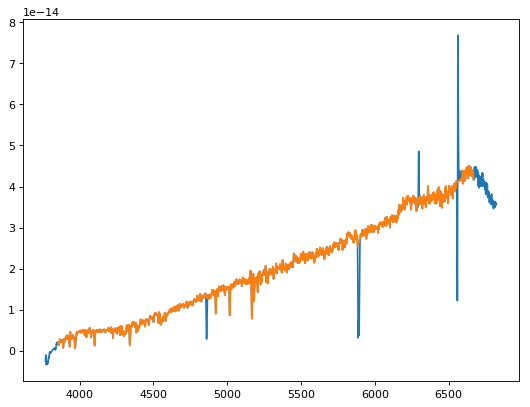

In [14]:
fig=plt.figure(figsize=(8, 6), dpi= 80)

plt.plot(wavesDATA_OPT, fluxesDATA_OPT)
wavesDATA_OPT_CLEAN, fluxesDATA_OPT_CLEAN = cleanPoints(wavesDATA_OPT, fluxesDATA_OPT, REGIONS_OPT)
plt.plot(wavesDATA_OPT_CLEAN, fluxesDATA_OPT_CLEAN)
plt.show()

In [23]:
REGIONS_OPT2 = np.array([(7.3e3, 7.78e3), (8.1e3, 8.4e3), (8.490e3, 8.505e3), (8.530e3, 8.555e3),\
                         (8.645e3, 8.665e3), (8.9e3, 9.2e33)])
wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN = cleanPoints(wavesDATA_OPT2, fluxesDATA_OPT2, REGIONS_OPT2)


C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


In [24]:
SPLIT_POINT = np.searchsorted(wavesDATA_OPT2_CLEAN, 8200)

In [25]:
SPLIT_POINT

804

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


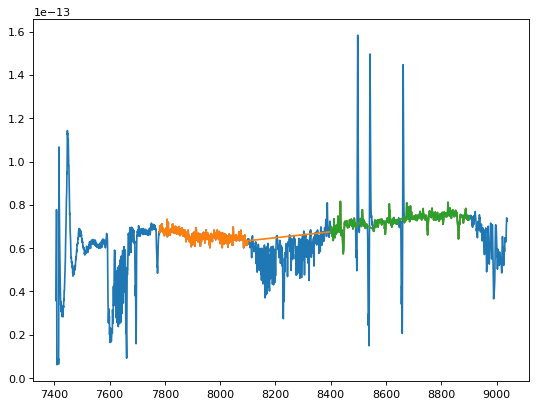

In [26]:
fig=plt.figure(figsize=(8, 6), dpi= 80)
plt.plot(wavesDATA_OPT2, fluxesDATA_OPT2)
wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN = cleanPoints(wavesDATA_OPT2, fluxesDATA_OPT2, REGIONS_OPT2)
plt.plot(wavesDATA_OPT2_CLEAN, fluxesDATA_OPT2_CLEAN)
plt.plot(wavesDATA_OPT2_CLEAN[SPLIT_POINT:], fluxesDATA_OPT2_CLEAN[SPLIT_POINT:])

## Reading infrared data

In [27]:
newtxt3 = getDataArray(PATH + 'hband_V1057Cyg.txt')

wavesDATA_INF = newtxt3[:,0] *1e4
fluxesDATA_INF = newtxt3[:,1]

newtxt4 = getDataArray(PATH + 'jband_V1057Cyg.txt')

wavesDATA_INF2 = newtxt4[:,0][10:] * 1e4
fluxesDATA_INF2 = newtxt4[:,1][10:]

newtxt5 = getDataArray(PATH + 'kband_V1057Cyg.txt')

wavesDATA_INF3 = newtxt5[:,0][10:] * 1e4
fluxesDATA_INF3 = newtxt5[:,1][10:]


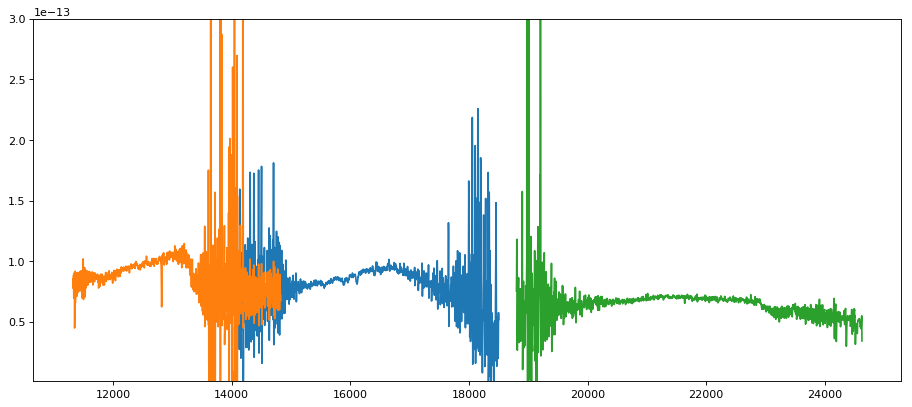

In [28]:
fig=plt.figure(figsize=(14, 6), dpi= 80)
plt.plot(wavesDATA_INF, fluxesDATA_INF)
plt.plot(wavesDATA_INF2, fluxesDATA_INF2)
plt.plot(wavesDATA_INF3, fluxesDATA_INF3)


plt.ylim(1e-15, 3e-13)
plt.show()

In [29]:
REGIONS = np.array([(1e3, 11.8e3), (13e3, 15.4e3), (17e3, 20.5e3), (23e3, 30e3)])

In [30]:
wavesDATA_INF, fluxesDATA_INF = cleanPoints(wavesDATA_INF, fluxesDATA_INF, REGIONS)
wavesDATA_INF2, fluxesDATA_INF2 = cleanPoints(wavesDATA_INF2, fluxesDATA_INF2, REGIONS)
wavesDATA_INF3, fluxesDATA_INF3 = cleanPoints(wavesDATA_INF3, fluxesDATA_INF3, REGIONS)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


In [31]:
waves_INF_LIST = [wavesDATA_INF, wavesDATA_INF2, wavesDATA_INF3]
fluxes_INF_LIST = [fluxesDATA_INF, fluxesDATA_INF2, fluxesDATA_INF3]

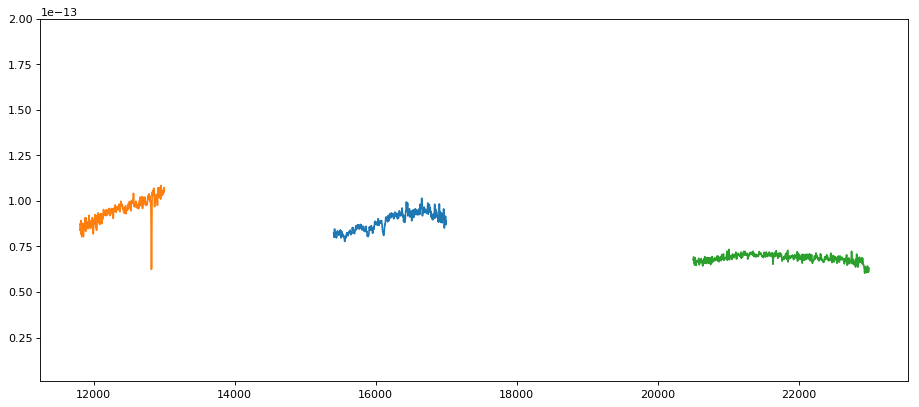

In [32]:
fig=plt.figure(figsize=(14, 6), dpi= 80)
plt.plot(wavesDATA_INF, fluxesDATA_INF)
plt.plot(wavesDATA_INF2, fluxesDATA_INF2)
plt.plot(wavesDATA_INF3, fluxesDATA_INF3)


plt.ylim(1e-15, 2e-13)
plt.show()

In [33]:
wav, lum = modSpec

In [34]:
x_atm = np.log10(wav*1e-4)
y_atm = np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))


### Plotting data with model

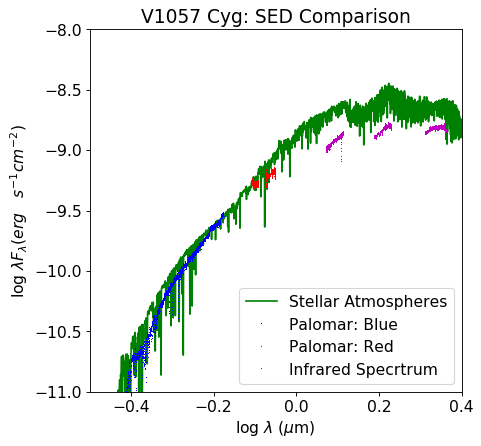

In [35]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
# plt.plot(x_bb, y_bb, \
#          'k-', alpha=1, label='Blackbody Disk Model')
plt.plot(x_atm, y_atm, \
         'g-', label='Stellar Atmospheres')
plt.plot(np.log10(wavesDATA_OPT_CLEAN*1e-4), np.log10(wavesDATA_OPT_CLEAN*fluxesDATA_OPT_CLEAN), marker=',', \
             linestyle='', color='b',label='Palomar: Blue')
plt.plot(np.log10(wavesDATA_OPT2_CLEAN*1e-4), np.log10(wavesDATA_OPT2_CLEAN*fluxesDATA_OPT2_CLEAN), marker=',', \
             linestyle='', color='r',label='Palomar: Red')
plt.plot(np.log10(wavesDATA_INF*1e-4), np.log10(wavesDATA_INF*fluxesDATA_INF*1.), marker=',', \
             linestyle='', color='m',label='Infrared Specrtrum')
plt.plot(np.log10(wavesDATA_INF2*1e-4), np.log10(wavesDATA_INF2*fluxesDATA_INF2*1.), marker=',', \
             linestyle='', color='m')
plt.plot(np.log10(wavesDATA_INF3*1e-4), np.log10(wavesDATA_INF3*fluxesDATA_INF3*1.), marker=',', \
             linestyle='', color='m')

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('V1057 Cyg: SED Comparison')
plt.ylim(-11, -8)
plt.xlim(-0.5, 0.4)
plt.legend()
plt.show()

### Working with cleaned data

In [36]:
x_list = [wavesDATA_OPT_CLEAN, wavesDATA_OPT2_CLEAN[:SPLIT_POINT], wavesDATA_OPT2_CLEAN[SPLIT_POINT:]]
y_list = [fluxesDATA_OPT_CLEAN, fluxesDATA_OPT2_CLEAN[:SPLIT_POINT], fluxesDATA_OPT2_CLEAN[SPLIT_POINT:]]

In [37]:
x_list_inf, y_list_inf = waves_INF_LIST, fluxes_INF_LIST

In [38]:
from scipy import interpolate

In [39]:
def resampleData(x_arr, y_arr, points, epsilon):
    logged_x = np.log10(x_arr*1e-4)
    logged_y = np.log10(y_arr*x_arr)
    x_min, x_max = np.min(logged_x), np.max(logged_x)
    logged_x_new = np.linspace(x_min + epsilon, x_max - epsilon, points)
    resample_interp = interpolate.interp1d(logged_x, logged_y, kind='linear')
    logged_y_new = resample_interp(logged_x_new)
    return logged_x_new, logged_y_new

### Optical resampling

In [44]:
x1, y1 = resampleData(x_list[0], y_list[0], 180, 0.01)
x2, y2 = resampleData(x_list[1], y_list[1], 8, 0.001)
x3, y3 = resampleData(x_list[2], y_list[2], 10, 0.001)    

### Infrared resampling

In [45]:
x1I, y1I = resampleData(x_list_inf[0], y_list_inf[0], 20, 0.003)
x2I, y2I = resampleData(x_list_inf[1], y_list_inf[1], 20, 0.003)
x3I, y3I = resampleData(x_list_inf[2], y_list_inf[2], 20, 0.003)    

### Model scaling

In [46]:
x_atm = np.log10(wav*1e-4)
y_atm = np.log10(wav*1e-8*lum*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

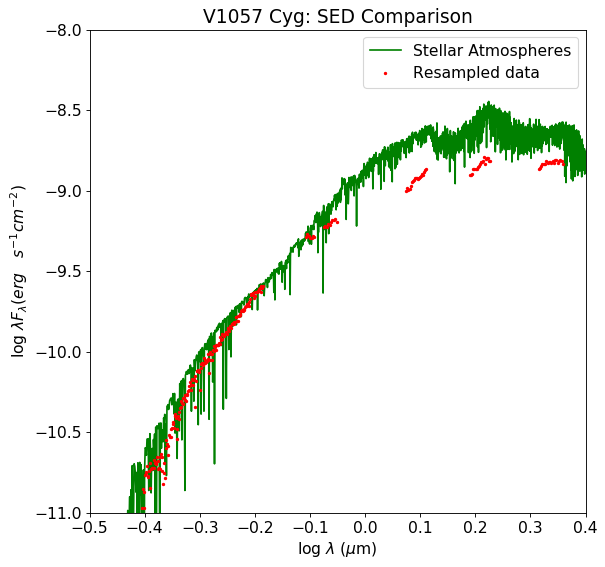

In [47]:
fig=plt.figure(figsize=(8, 8), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(x_atm, y_atm, \
         'g-', label='Stellar Atmospheres')
# plt.plot(np.log10(x_data*1e-4), np.log10(y_data*x_data), '-', label='Full data points')
plt.plot(x1,y1, 'ro', markersize=2, label='Resampled data')
plt.plot(x2,y2, 'ro', markersize=2)
plt.plot(x3,y3, 'ro', markersize=2)

plt.plot(x1I,y1I, 'ro', markersize=2)
plt.plot(x2I,y2I, 'ro', markersize=2)
plt.plot(x3I,y3I, 'ro', markersize=2)


plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('V1057 Cyg: SED Comparison')
plt.ylim(-11, -8)
plt.xlim(-0.5, 0.4)
plt.legend()
plt.show()

In [48]:
WAV_OUT = np.concatenate((x1, x2, x3, x1I, x2I, x3I))

In [49]:
FLUX_OUT = np.concatenate((y1, y2, y3, y1I, y2I, y3I))

In [50]:
import csv
with open('v1057_out.csv', 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(zip(WAV_OUT, FLUX_OUT))